<a href="https://colab.research.google.com/github/BrunoAFurquim/SugarcaneDiseaseClassification_ControlledDataset/blob/main/SugarcaneClassification_ControlledModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib numpy
!pip install gdown -q
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import os
from google.colab import files
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Banded Chlorosis.zip to Banded Chlorosis.zip
Saving Brown Spot.zip to Brown Spot.zip
Saving BrownRust.zip to BrownRust.zip
Saving Dried Leaves.zip to Dried Leaves.zip
Saving Grassy shoot.zip to Grassy shoot.zip
Saving Healthy Leaves.zip to Healthy Leaves.zip
Saving Pokkah Boeng.zip to Pokkah Boeng.zip
Saving Sett Rot.zip to Sett Rot.zip
Saving Viral Disease.zip to Viral Disease.zip
Saving Yellow Leaf.zip to Yellow Leaf.zip


In [ ]:
from collections import defaultdict

class_zips = {
    'Banded Chlorosis': 'Banded Chlorosis.zip',
    'Brown Rust': 'Brown Rust.zip',
    'Brown Spot': 'Brown Spot.zip',
    'Dried': 'Dried.zip',
    'Grassy Shoot': 'Grassy Shoot.zip',
    'Healthy': 'Healthy.zip',
    'Mosaic': 'Mosaic.zip',
    'Pokkah Boeng': 'Pokkah Boeng.zip',
    'Sett Rot': 'Sett Rot.zip',
    'Smut': 'Smut.zip',
    'Yellow Leaf Disease': 'Yellow Leaf Disease.zip'
}

CONTROLLED_CLASSES = [
    'Banded Cholorsis',
    'Brown Rust',
    'Brown Spot',
    'Dried',
    'Grassy Shoot',
    'Healthy',
    'Mosaic',
    'Pokkah Boeng',
    'Sett Rot',
    'Smut',
    'Yellow Leaf Disease'
]

class_stats = defaultdict(lambda: {
    'heights': [],
    'widths': [],
    'means_rgb': [],       # Lista de arrays [R_mean, G_mean, B_mean] por imagem
    'stds_rgb': [],        # Lista de arrays [R_std, G_std, B_std] por imagem
    'correlation_rg': [],  # Correlação entre R e G
    'correlation_rb': [],  # Correlação entre R e B
    'correlation_gb': [],  # Correlação entre G e B
    'dominant_color': [],  # Canal dominante (R, G ou B)
    'image_paths': [],
    'unique_files': set()
})

Iniciando a descompactação dos arquivos...
-> Arquivo 'Banded Chlorosis.zip' descompactado em './controlled_dataset_unzipped/Banded Chlorosis'
-> Arquivo 'Brown Spot.zip' descompactado em './controlled_dataset_unzipped/Brown Spot'
-> Arquivo 'BrownRust.zip' descompactado em './controlled_dataset_unzipped/Brown Rust'
-> Arquivo 'Dried Leaves.zip' descompactado em './controlled_dataset_unzipped/Dried'
-> Arquivo 'Grassy shoot.zip' descompactado em './controlled_dataset_unzipped/Grassy Shoot'
-> Arquivo 'Healthy Leaves.zip' descompactado em './controlled_dataset_unzipped/Healthy'
-> Arquivo 'Viral Disease.zip' descompactado em './controlled_dataset_unzipped/Mosaic'
-> Arquivo 'Pokkah Boeng.zip' descompactado em './controlled_dataset_unzipped/Pokkah Boeng'
-> Arquivo 'Sett Rot.zip' descompactado em './controlled_dataset_unzipped/Sett Rot'
-> Arquivo 'Yellow Leaf.zip' descompactado em './controlled_dataset_unzipped/Yellow Leaf Disease'

Descompactação concluída!
----------------------------

/tmp/ipython-input-282748848.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


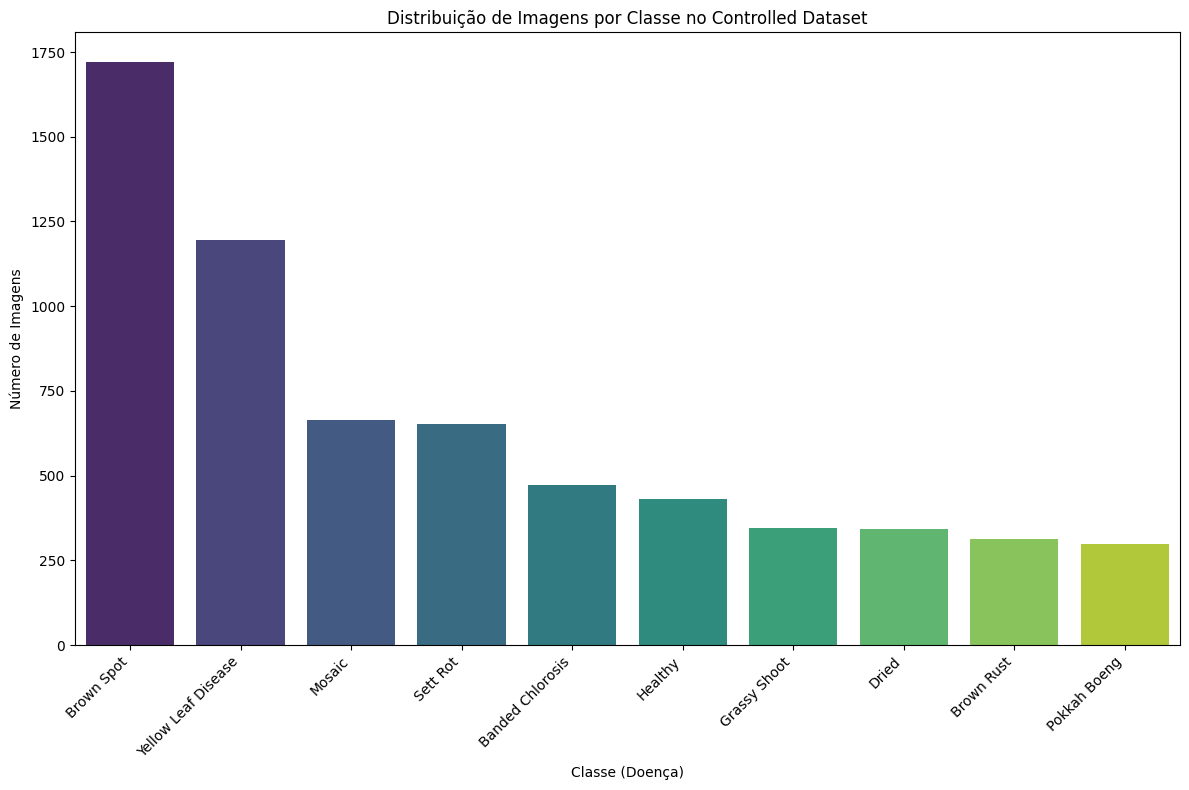

In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==============================================================================
# 1. DESCOMPACTAR OS ARQUIVOS .ZIP CARREGADOS (Esta parte já funcionou, mantemos igual)
# ==============================================================================
print("Iniciando a descompactação dos arquivos...")

files_to_unzip = {
    'Banded Chlorosis.zip': 'Banded Chlorosis',
    'Brown Spot.zip': 'Brown Spot',
    'BrownRust.zip': 'Brown Rust',
    'Dried Leaves.zip': 'Dried',
    'Grassy shoot.zip': 'Grassy Shoot',
    'Healthy Leaves.zip': 'Healthy',
    'Viral Disease.zip': 'Mosaic',
    'Pokkah Boeng.zip': 'Pokkah Boeng',
    'Sett Rot.zip': 'Sett Rot',
    'Yellow Leaf.zip': 'Yellow Leaf Disease'
}

DATASET_PATH = './controlled_dataset_unzipped'
os.makedirs(DATASET_PATH, exist_ok=True)

for zip_filename, class_name in files_to_unzip.items():
    if os.path.exists(zip_filename):
        extract_path = os.path.join(DATASET_PATH, class_name)
        if not os.path.exists(extract_path):
             os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"-> Arquivo '{zip_filename}' descompactado em '{extract_path}'")
    else:
        print(f"AVISO: Arquivo '{zip_filename}' não encontrado. Pulando.")

print("\nDescompactação concluída!")
print("-" * 50)


# ==============================================================================
# 2. CARREGAR DADOS EM UM DATAFRAME (VERSÃO CORRIGIDA)
# ==============================================================================

def load_dataset_recursively(path):
    """
    Carrega os caminhos das imagens e rótulos de forma recursiva,
    procurando em todas as subpastas.
    """
    filepaths = []
    labels = []

    class_folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    print(f"Encontradas as seguintes classes: {class_folders}")

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        # os.walk() percorre a pasta e todas as suas subpastas
        for root, dirs, files in os.walk(class_path):
            for file in files:
                # Verificamos se o arquivo é uma imagem
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(root, file))
                    labels.append(class_name)

    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    return df

# Carregando o dataset com a nova função robusta
df_controlled = load_dataset_recursively(DATASET_PATH)

if df_controlled.empty:
    print("\nERRO: Nenhuma imagem foi carregada. Verifique a estrutura das pastas descompactadas.")
else:
    print(f"\nSUCESSO! Total de imagens carregadas: {len(df_controlled)}")
    print(df_controlled.head())

    # ==============================================================================
    # 3. ANÁLISE EXPLORATÓRIA (EDA)
    # ==============================================================================
    print("\n" + "="*50)
    print("Iniciando Análise Exploratória do Controlled Dataset")
    print("="*50)

    class_counts = df_controlled['label'].value_counts()
    print("\nDistribuição de imagens por classe:")
    print(class_counts)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Distribuição de Imagens por Classe no Controlled Dataset')
    plt.xlabel('Classe (Doença)')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# ==============================================================================
# 1. DIVISÃO ESTRATIFICADA DOS DADOS
# ==============================================================================
print("Dividindo o dataset em conjuntos de treino, validação e teste...")

# Divisão em 80% treino e 20% para validação/teste
train_df, temp_df = train_test_split(
    df_controlled,
    test_size=0.2,
    random_state=42,
    stratify=df_controlled['label'] # Mantém a proporção das classes em ambos os conjuntos
)

# Divisão do restante em 10% validação e 10% teste
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"  - Tamanho do conjunto de treino: {len(train_df)}")
print(f"  - Tamanho do conjunto de validação: {len(validation_df)}")
print(f"  - Tamanho do conjunto de teste: {len(test_df)}")
print("-" * 50)


# ==============================================================================
# 2. CÁLCULO DOS PESOS PARA COMBATER O DESBALANCEAMENTO
# ==============================================================================
print("Calculando os pesos das classes para a função de perda...")

# Extrai os rótulos do conjunto de treinamento
y_train_labels = train_df['label'].values

# Obtém a lista única de classes na ordem correta
class_names = np.unique(y_train_labels)

# Calcula os pesos das classes. A biblioteca faz isso de forma inversamente
# proporcional à frequência da classe.
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=class_names,
    y=y_train_labels
)

# Mapeia os pesos para um dicionário, que é o formato esperado pelo Keras.
# O gerador de dados mapeia nomes de classes para índices numéricos.
# Precisamos garantir que nossos pesos correspondam a esses índices.
class_indices = {class_name: i for i, class_name in enumerate(class_names)}
class_weights = {class_indices[name]: weight for name, weight in zip(class_names, class_weights_array)}

print("Pesos calculados para cada classe (índice: peso):")
print(class_weights)
print("-" * 50)


# ==============================================================================
# 3. CRIAÇÃO DOS GERADORES DE DADOS (DATA AUGMENTATION)
# ==============================================================================
print("Configurando o Data Augmentation e criando os geradores de dados...")

# Parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Gerador para o conjunto de treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador para validação e teste (apenas normalização)
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Criando os geradores a partir dos DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Não é necessário embaralhar os dados de validação
)

test_generator = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Não é necessário embaralhar os dados de teste
)

# Importante: O Keras precisa saber o mapeamento de classe para índice que o gerador criou.
# Vamos inverter o dicionário de pesos para referência, se necessário.
label_map = train_generator.class_indices
print("\nMapeamento de classes para índices feito pelo gerador:")
print(label_map)
print("\nGeradores de dados prontos!")

# Para usar os pesos no treinamento, você passará o dicionário `class_weights`
# para o parâmetro `class_weight` na chamada `model.fit()`.

Dividindo o dataset em conjuntos de treino, validação e teste...
  - Tamanho do conjunto de treino: 5145
  - Tamanho do conjunto de validação: 643
  - Tamanho do conjunto de teste: 644
--------------------------------------------------
Calculando os pesos das classes para a função de perda...
Pesos calculados para cada classe (índice: peso):
{0: np.float64(1.3647214854111407), 1: np.float64(2.049800796812749), 2: np.float64(0.37363834422657954), 3: np.float64(1.8777372262773722), 4: np.float64(1.8574007220216606), 5: np.float64(1.495639534883721), 6: np.float64(0.970754716981132), 7: np.float64(2.161764705882353), 8: np.float64(0.985632183908046), 9: np.float64(0.5387434554973822)}
--------------------------------------------------
Configurando o Data Augmentation e criando os geradores de dados...
Found 5145 validated image filenames belonging to 10 classes.
Found 643 validated image filenames belonging to 10 classes.
Found 644 validated image filenames belonging to 10 classes.

Mapea

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==============================================================================
# 1. DEFINIÇÃO DA ARQUITETURA DO MODELO
# ==============================================================================
print("Construindo o modelo com a base InceptionV3...")

# Carrega o modelo InceptionV3 pré-treinado no ImageNet, sem a camada de classificação final
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Congela todas as camadas do modelo base.
# Seus pesos não serão atualizados durante este primeiro treinamento.
base_model.trainable = False
print(f"O modelo base InceptionV3 tem {len(base_model.layers)} camadas e está congelado.")

# Adiciona a nossa cabeça de classificação personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x) # Converte os mapas de features em um vetor único
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout para regularização, prevenindo overfitting
outputs = Dense(len(label_map), activation='softmax')(x) # Camada de saída com neurônios para cada classe

# Cria o modelo final
model = Model(inputs=base_model.input, outputs=outputs)

print("\nArquitetura do modelo final criada.")
model.summary()
print("-" * 50)


# ==============================================================================
# 2. COMPILAÇÃO DO MODELO
# ==============================================================================
print("Compilando o modelo...")

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Modelo compilado com sucesso.")
print("-" * 50)


# ==============================================================================
# 3. CONFIGURAÇÃO DOS CALLBACKS
# ==============================================================================
print("Configurando os callbacks...")

# Para o treinamento se a perda na validação não melhorar após 'patience' épocas
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Reduz a taxa de aprendizado se a perda na validação estagnar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduz a LR por um fator de 5
    patience=4,
    min_lr=1e-6,
    verbose=1
)

print("Callbacks EarlyStopping e ReduceLROnPlateau estão prontos.")
print("-" * 50)


# ==============================================================================
# 4. TREINAMENTO DO MODELO
# ==============================================================================
print("Iniciando o treinamento do modelo (Fase 1)...")

# Número de épocas para o treinamento
EPOCHS = 50

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights # <--- AQUI aplicamos os pesos contra o desbalanceamento
)

print("\nTreinamento concluído!")

# ==============================================================================
# 5. VISUALIZAÇÃO DOS RESULTADOS DO TREINAMENTO
# ==============================================================================

# Extrai o histórico de acurácia e perda
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.show()

Construindo o modelo com a base InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
O modelo base InceptionV3 tem 311 camadas e está congelado.

Arquitetura do modelo final criada.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,857,002 (87.19 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

--------------------------------------------------
Compilando o modelo...
Modelo compilado com sucesso.
--------------------------------------------------
Configurando os callbacks...
Callbacks EarlyStopping e ReduceLROnPlateau estão prontos.
--------------------------------------------------
Iniciando o treinamento do modelo (Fase 1)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 917s 6s/step - accuracy: 0.3584 - loss: 1.9123 - val_accuracy: 0.6112 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 889s 6s/step - accuracy: 0.5700 - loss: 1.0371 - val_accuracy: 0.6858 - val_loss: 0.8809 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 894s 6s/step - accuracy: 0.6230 - loss: 0.9248 - val_accuracy: 0.7496 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 961s 6s/step - accuracy: 0.6342 - loss: 0.8372 - val_accuracy: 0.6936 - val_loss: 0.8468 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 874s 5s/step - accuracy: 0.6498 - loss: 0.7747 - val_accuracy: 0.7449 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6722 - loss: 0.7698